In [50]:
from gensim.models.word2vec import Word2Vec as w2
from gensim import corpora, models, similarities
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn
from nltk import word_tokenize
from nltk.corpus import stopwords
import plotly.plotly as py
import plotly.graph_objs as go
import plotly.tools as tls
import numpy as np
import sklearn as sc
import os
import json

% matplotlib inline

In [5]:
data_dir = '/Users/christopherallison/Documents/Coding/Data'
home_dir = '/Users/christopherallison/.virtualenvs/py_twi/streaming_results'

In [6]:
model = w2.load_word2vec_format(os.path.join(data_dir, 'GoogleNews-vectors-negative300.bin'), binary=True)

In [7]:
model.most_similar(positive=['crazy', 'man', 'good'], negative=['old'], topn=5)

[('weird', 0.5910420417785645),
 ('nice', 0.5751094222068787),
 ('mad', 0.5641375780105591),
 ('bad', 0.5630226135253906),
 ('stupid', 0.5552173256874084)]

In [8]:
def load_tweets(target):
    # Output list of tweets
    tweets = []

    with open(os.path.join(home_dir, target)) as f:
        for data in f:

            result = json.loads(data)
            
            try:
                tweets.append(result['text'])
            except KeyError:
                continue
    
    return tweets

In [9]:
def process_tweets(tweets):
    # Output processed list of tweets

    texts = [[word for word in tweet.lower().split() if word not in stopwords.words('english') and
            word not in stopwords.words('french')] for tweet in tweets]
    
    # Remove words that only occur once
    from collections import defaultdict
    frequency = defaultdict(int)
    for text in texts:
        for token in text:
            frequency[token] += 1

    texts = [[token for token in text if frequency[token] > 1] for text in texts]

    from pprint import pprint
    #pprint(texts)
    
    return texts


Graph sentiment across Pleasure/Displeasure and Active/Passive as per the Russel and Pratt affect grid

http://richardcoyne.com/2013/10/05/absence-of-melancholy/

In [11]:
def analyze_sentiment(texts):
    # Output dictionary of tweets and sentiment scores for pleasure and activity
    
    tweet_sentiments = {}

    for i, text in enumerate(texts):
        pleasure = 0
        displeasure = 0
        active = 0
        passive = 0
        for word in text:
            try:
                pleasure += model.similarity('pleasure', word)
                displeasure += model.similarity('displeasure', word)
                active += model.similarity('active', word)
                passive += model.similarity('passive', word)
            except KeyError:
                continue
                
        tweet_sentiments[i] = {'text':text, 'pleasure':pleasure - displeasure,
                           'active':active - passive}
        #print("Tweet {} Sentiment: pleasure {} active {}".format(i, pleasure - displeasure, active - passive))

    return tweet_sentiments

In [12]:
def prepare_coords(tweet_sentiments):
    # Output list of coordinates in tuple (x, y)
    coordinates = []

    for tweet in tweet_sentiments:
        x = tweet_sentiments[tweet]['pleasure'] - tweet_sentiments[tweet]['displeasure']
        y = tweet_sentiments[tweet]['active'] - tweet_sentiments[tweet]['passive']

        coordinates.append((x, y))
        
    return coordinates

In [31]:
def graph_tweets(tweet_sentiments, title):
    # Accepts dictionary of tweet sentiments & title, outputs graph and stats
    
    anger = 0
    excitement = 0
    content = 0
    sorrow = 0
    
    pleasure_sum = 0.0
    active_sum = 0.0
    
    plt.figure(figsize=(20,10))

    for tweet in tweet_sentiments:
        x = tweet_sentiments[tweet]['pleasure']
        y = tweet_sentiments[tweet]['active']
        
        pleasure_sum += x
        active_sum += y

        if x > 0 and y > 0:
            color = 'b'
            excitement += 1
        elif x < 0 and y > 0:
            color = 'r'
            anger += 1
        elif x > 0 and y < 0:
            color = 'g'
            content += 1
        else:
            color = 'y'
            sorrow += 1

        plt.plot(x, y, marker='o', markersize=8, color=color)
    
    plt.xlabel('pleasure')
    plt.ylabel('activity')
    plt.title('Sentiment Analysis of Tweets: {}'.format(title))
    
    plt.grid(True)
    blue_patch = mpatches.Patch(color='blue', label="Excitement")
    red_patch = mpatches.Patch(color='red', label='Anger')
    green_patch = mpatches.Patch(color='green', label='Content')
    yellow_patch = mpatches.Patch(color='yellow', label='Sorrow')
    
    plt.axvline(0)
    plt.axhline(0)

    first_legend = plt.legend(handles=[blue_patch], loc=1)
    second_legend = plt.legend(handles=[red_patch], loc=2)
    third_legend = plt.legend(handles=[green_patch], loc=4)
    fourth_legend = plt.legend(handles=[yellow_patch], loc=3)
    
    ax = plt.gca().add_artist(first_legend)
    ax = plt.gca().add_artist(second_legend)
    ax = plt.gca().add_artist(third_legend)
    
    print("Mood Breakdown for {}".format(title))
    print("Total Tweets: {}".format(len(tweet_sentiments)))
    print('Average Pleasure: {}'.format(pleasure_sum / len(tweet_sentiments)))
    print('Average Active: {}'.format(active_sum / len(tweet_sentiments)))
    print("*****")
    print('Excitement: {}%'.format(excitement / len(tweet_sentiments)))
    print('Content: {}%'.format(content / len(tweet_sentiments)))
    print('Anger: {}%'.format(anger / len(tweet_sentiments)))
    print('Sorrow: {}%\n'.format(sorrow / len(tweet_sentiments)))
    

In [61]:
# Plotly scatter
def plotly_graph_tweets(tweet_sentiments, title):
    
    x_coords = []
    y_coords = []
    texts = []
    color = []

    for tweet in tweet_sentiments:
        x = tweet_sentiments[tweet]['pleasure']
        y = tweet_sentiments[tweet]['active']
            
        x_coords.append(x)
        y_coords.append(y)
        texts.append(tweet_sentiments[tweet]['text'])
        
        if x > 0 and y > 0:
            color.append('blue')
        elif x < 0 and y > 0:
            color.append('red')
        elif x > 0 and y < 0:
            color.append('green')
        else:
            color.append('yellow')

    trace0 = go.Scatter(
        x=x_coords,
        y=y_coords,
        mode='markers',
        name=title,
        text=texts,
        marker=dict(
            size=8,
            color=color,
        )
    )


    data = [trace0]
    layout = go.Layout(

        xaxis=dict(
            range=[-2.0, 2.0],
            autorange=False,
        ),

        yaxis=dict(
            range=[-2.0, 2.0],
            autorange=False,
        ),
    )
    fig = go.Figure(data=data, layout=layout)
    py.iplot(fig, filename='{} Plot'.format(title))

![Graph](http://rcoyne99.files.wordpress.com/2013/10/screen-shot-2013-10-05-at-15-37-13.png?w=800&h=730)

In [32]:
trudeau_tweets = load_tweets('trudeau_stream.json')
processed_trudeau_tweets = process_tweets(trudeau_tweets)
sentiment_trudeau = analyze_sentiment(processed_trudeau_tweets)

In [53]:
harper_tweets = load_tweets('harper_stream.json')
processed_harper_tweets = process_tweets(harper_tweets)
sentiment_harper = analyze_sentiment(processed_harper_tweets)

Mood Breakdown for Trudeau
Total Tweets: 85
Average Pleasure: -0.04959779441458262
Average Active: -0.0648034856878402
*****
Excitement: 0.03529411764705882%
Content: 0.21176470588235294%
Anger: 0.2%
Sorrow: 0.5529411764705883%



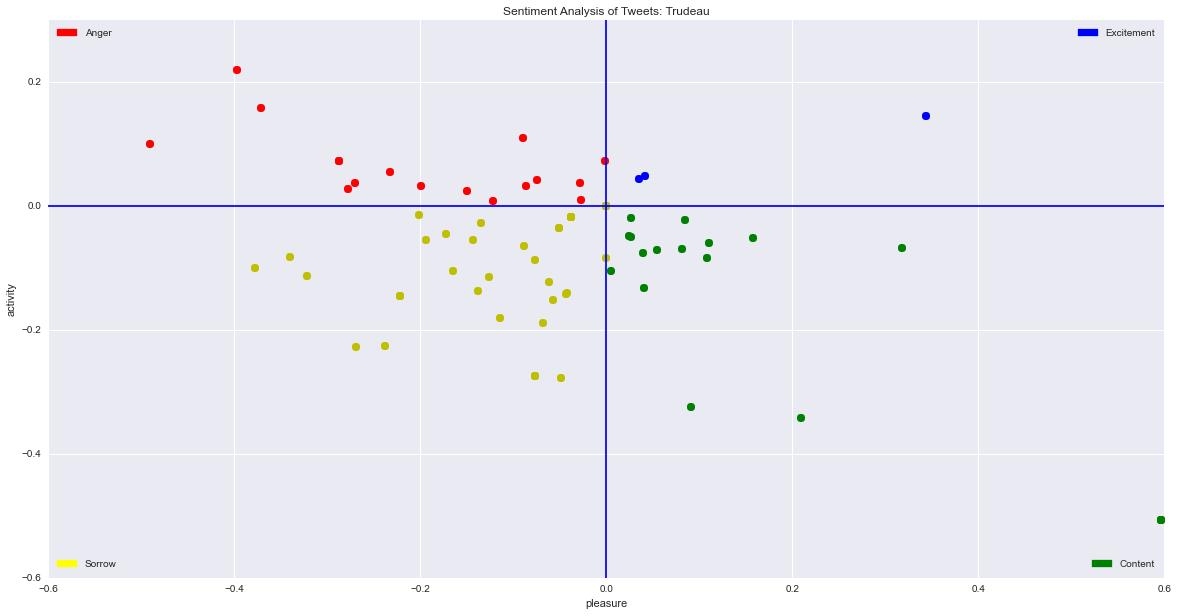

In [33]:
graph_tweets(sentiment_trudeau, 'Trudeau')

In [62]:
plotly_graph_tweets(sentiment_trudeau, 'Trudeau')

Mood Breakdown for Harper
Total Tweets: 356
Average Pleasure: -0.008899473585517195
Average Active: -0.13302219271607593
*****
Excitement: 0.0898876404494382%
Content: 0.41292134831460675%
Anger: 0.12921348314606743%
Sorrow: 0.36797752808988765%



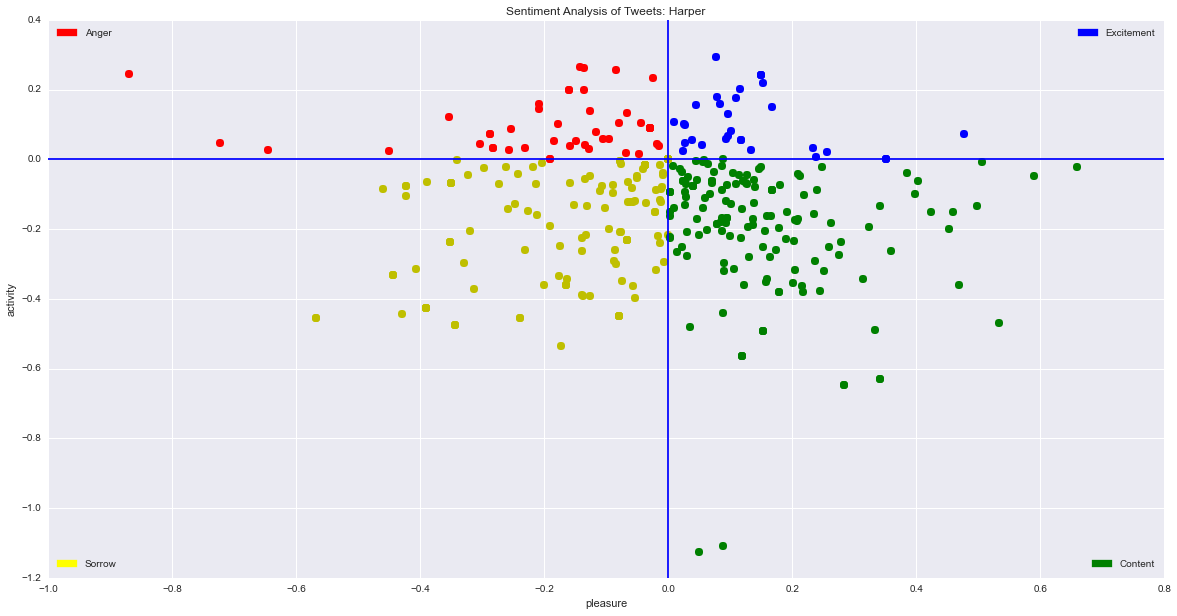

In [17]:
graph_tweets(sentiment_harper, "Harper")

In [18]:
demdebate_tweets = load_tweets('demdebate_stream.json')
processed_demdebate_tweets = process_tweets(demdebate_tweets)
sentiment_demdebate = analyze_sentiment(processed_demdebate_tweets)

Mood Breakdown for DemDebate
Total Tweets: 16032
Average Pleasure: 0.0615434300221084
Average Active: -0.09249508150147576
*****
Excitement: 0.14283932135728544%
Content: 0.43026447105788423%
Anger: 0.12418912175648703%
Sorrow: 0.3027070858283433%



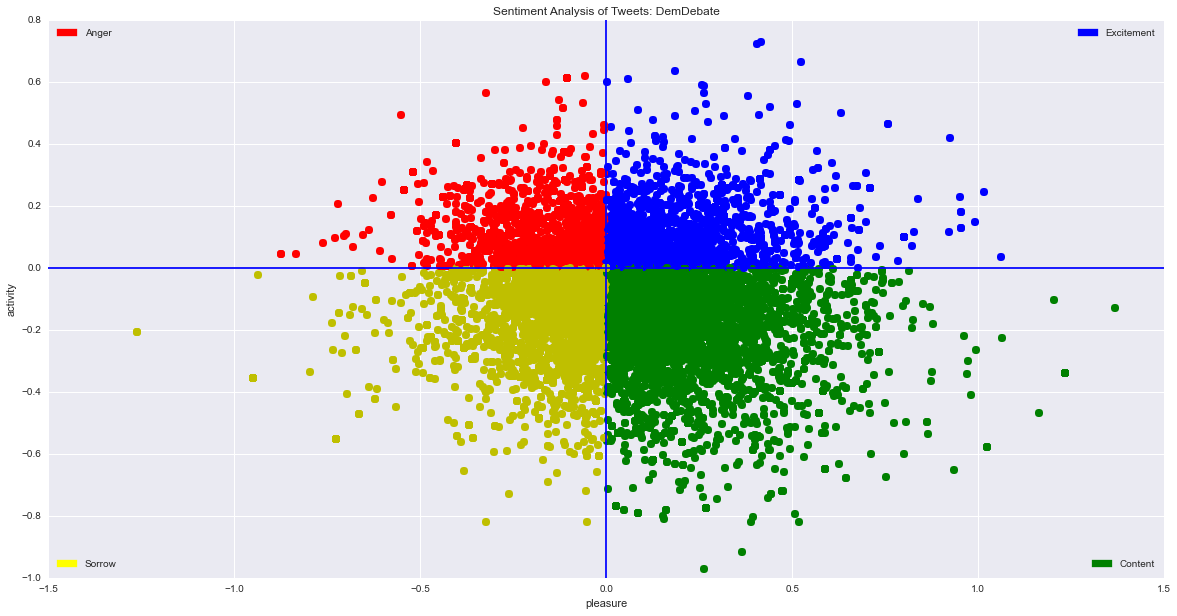

In [19]:
graph_tweets(sentiment_demdebate, "DemDebate")

In [20]:
class MyTweets(object):
    def __init__(self, target):
        self.target = target
    
    def __iter__(self):
        for line in open(os.path.join(home_dir, self.target)):
            result = json.loads(line)
            text = result['text']
            yield dictionary.doc2bow(text.lower().split())

[(2, 1), (31, 1), (35, 1), (52, 1), (213, 1), (217, 1), (220, 1), (249, 1), (250, 1), (378, 1), (406, 1)]
[(20, 1), (63, 1), (131, 1), (133, 1), (178, 1), (181, 1), (188, 1), (248, 1), (362, 1)]
[(2, 1)]
[(72, 1), (123, 1), (199, 1), (272, 1)]
[(2, 1), (29, 1), (123, 1), (127, 1), (128, 1), (129, 1), (130, 1), (131, 1), (132, 1), (133, 1), (134, 1), (135, 1), (136, 1), (137, 1)]
[(26, 1), (96, 1), (131, 1), (172, 1), (201, 1), (275, 1), (378, 1)]
[(22, 1), (24, 1), (34, 1), (44, 1), (101, 1), (131, 1)]
[(2, 1), (29, 1), (48, 1), (53, 1), (101, 1), (109, 1), (143, 1), (197, 1), (198, 1), (199, 1), (200, 1), (201, 1)]
[(46, 1), (48, 1), (106, 1), (131, 1), (272, 1)]
[(131, 1)]
[(163, 1)]
[(2, 1), (54, 1), (121, 1), (128, 1), (172, 1), (192, 1), (359, 1)]
[(2, 1), (29, 1), (65, 1), (92, 1), (111, 1), (131, 1), (178, 1), (268, 1), (269, 1), (270, 1)]
[(1, 1), (29, 1), (34, 1), (276, 1), (277, 1)]
[(2, 1), (46, 1), (49, 1), (97, 1), (131, 1), (220, 1), (354, 1)]
[(2, 1), (26, 1), (96, 1), (

In [115]:
def getWordVecs(text):
    vecs = []
    for word in text:
        try:
            vecs.append(model[word].reshape(1,300))
        except KeyError:
            continue
    vecs = np.concatenate(vecs)
    return np.array(vecs, dtype='float')


In [117]:
tweet_text = []

for line in open(os.path.join(home_dir, 'harper_stream.json')):
    result = json.loads(line)
    text = result['text']
    tweet_text.append(text)

In [119]:
tweet_text


['RT @BD_CDA: @MrDash109 @___Danno Gopnik writes: "Stephen Harper—a charmless but effective politician". Effective? How about "charmless but …',
 'RT @JustinTrudeau: To stop Stephen Harper, we need you to vote. Find your advance polling location: http://t.co/RtSzoTP9cc http://t.co/GOfO…',
 'Vote ABC https://t.co/4kXESMVXwu',
 '@1planet_People your an idiot. Harper best prime minister in last 40 yrs.  your a regressive liberal and make no sense',
 "RT @Bollyone: Check Out @sonamakapoor @BeingSalmanKhan stunning Shoot Harper's Bazaar Bride Magazine http://t.co/rJ1nPgLD0M http://t.co/YrV…",
 'Sign! RT! I just signed this petition, please join me: http://t.co/z6nxm9lq5P via @leadnowca',
 "It's positive you agree we have a surplus in 2015. Which is what matters https://t.co/JsVkTjBbB8",
 "RT So happy you voted! This early turnout bodes well for Canada! Can't wait to see the back of &amp; bring back our de… https://t.co/CZmUyEu6zZ",
 "aviateur1954Au contraire net recul avec Harper ex :l'inte